In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt



In [4]:
list_ds = tf.data.Dataset.list_files('/home/vimalkumar/Documents/tablenet/input/*.xml')


In [5]:
img_height, img_width = 256, 256
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img,channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])
def decode_mask_img(img):
    # convert the compressed string to a 2D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])
def process_path(file_path):
    file_path = tf.strings.regex_replace(file_path, '.xml', '.jpeg')
    print(file_path)
    mask_file_path = tf.strings.regex_replace(file_path, '.jpeg', '.jpeg')
    print(mask_file_path)
    table_mask_file_path = tf.strings.regex_replace(mask_file_path,'input', 'table_mask')
    print(table_mask_file_path)
    column_mask_file_path = tf.strings.regex_replace(mask_file_path,'input', 'column_mask')
    print(column_mask_file_path)
    img = normalize(decode_img(tf.io.read_file(file_path)))
    table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
    column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))
    return img, {"table_output" : table_mask, "column_output" : column_mask }

In [6]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)
train = list_ds.take(train_size)
test = list_ds.skip(train_size)
TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
train = train.shuffle(BUFFER_SIZE)
train = train.map(process_path,
num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.map(process_path)
train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_1:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_2:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_3:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_1:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_2:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_3:0", shape=(), dtype=string)


In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2021-12-23 10:36:07.729708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(256, 256, 3)


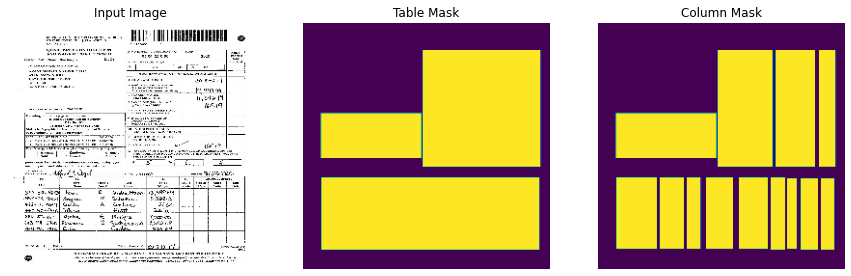

(256, 256, 3)


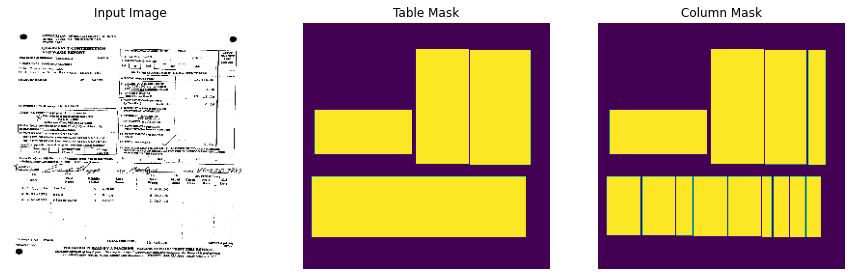

(256, 256, 3)


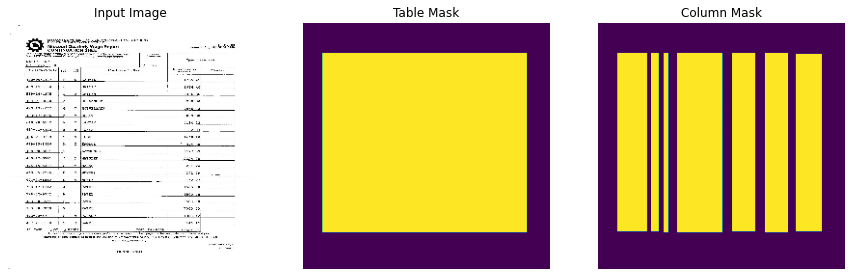

(256, 256, 3)


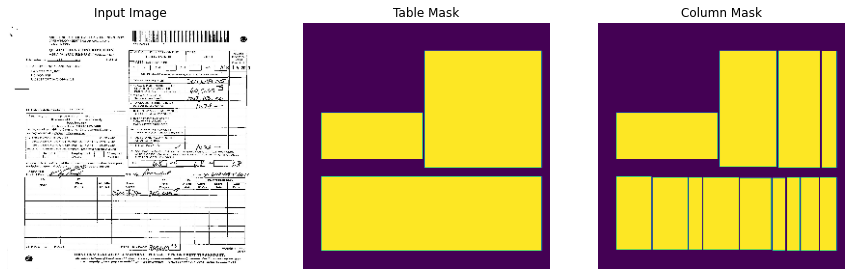

(256, 256, 3)


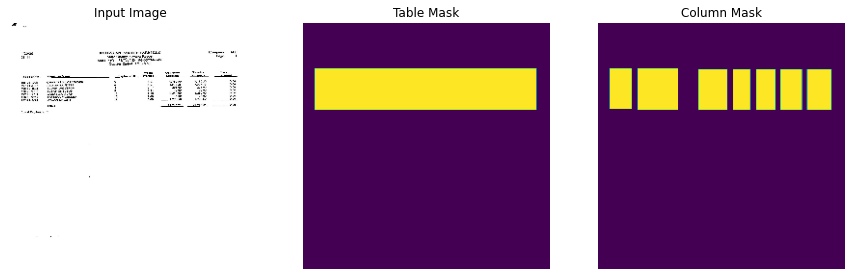

In [8]:
for image, mask in train.take(5):
    print(image.shape)
# print(mask.shape)
    display([image, mask['table_output'], mask['column_output']])

In [9]:
from tensorflow import keras
model = keras.models.load_model('mymodel_11')

In [10]:
val = tf.data.Dataset.list_files('/home/vimalkumar/Documents/File Samples/23.12.2021/output/*.jpeg')


In [11]:
val_size = len(list(val))
val_int = int(val_size)
test_val = val.take(val_int)
val_test = test_val.map(process_path)
val_dataset = val_test.batch(BATCH_SIZE)


Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_1:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_2:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_3:0", shape=(), dtype=string)


In [14]:
def create_mask(pred_mask1, pred_mask2):
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis]
    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask2 = pred_mask2[..., tf.newaxis]
    return pred_mask1[0], pred_mask2[0]

In [15]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask1, sample_mask2 = image, mask['table_output'],mask['column_output']
    def show_predictions(dataset=None, num=1):
        if dataset:
            for image, (mask1, mask2) in dataset.take(num):
                pred_mask1, pred_mask2 = model.predict(image, verbose=1)
                table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
                display([image[0], table_mask, column_mask])
        else:
            pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
            table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
            display([sample_image[0], table_mask, column_mask])

1/1 [==============================] - 2s 2s/step


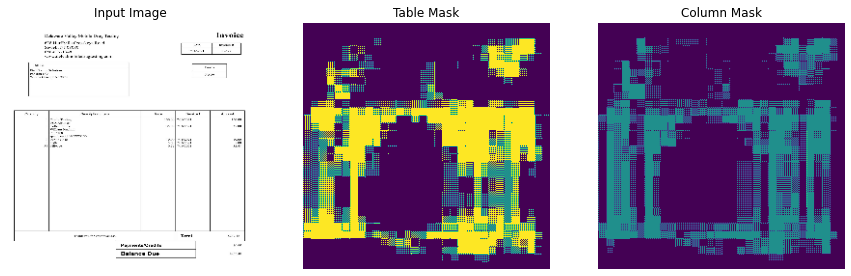

In [17]:
show_predictions(val_dataset,2)